# 1. 데이터 이해와 전처리

In [3]:
!pip install konlpy
# !pip install tensorflow

     |████████████████████████████████| 19.4 MB 1.4 MB/s 
     |████████████████████████████████| 448 kB 46.6 MB/s 


In [4]:
# 데이터 처리 라이브러리
import pandas as pd
import numpy as np
import re

# 데이터 시각화
import matplotlib.pyplot as plt

# 자연어처리를 위한 라이브러리
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from konlpy.tag import Okt

# 모델링
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import *

# 기타
from tqdm import tqdm
import urllib.request
import warnings
warnings.filterwarnings(action='ignore')

## 1) 데이터 로드하기    
https://github.com/e9t/nsmc/ 로부터 훈련 데이터(ratings_train.txt)와 테스트 데이터(ratings_test.txt)를 다운로드합니다.

In [5]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [6]:
print(train_data.shape, test_data.shape)

(150000, 3) (50000, 3)


In [7]:
train_data.tail(2)

,id,document,label
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1
149999,9619869,한국 영화 최초로 수간하는 내용이 담긴 영화,0


## 2) 데이터 정제하기

In [8]:
# document 열과 label 열의 중복을 제외한 값의 개수
train_data['document'].nunique(), train_data['label'].nunique()

(146182, 2)

In [9]:
# document 열의 중복 제거
train_data.drop_duplicates(subset=['document'], inplace=True)

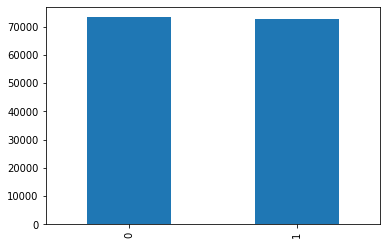

In [10]:
# 클래스 분포 확인
# .plot(kind='bar') 제외하면 숫자로 보여짐
train_data['label'].value_counts().plot(kind='bar')

In [11]:
# 데이터 중에 Null 값을 가진 샘플이 있는지 확인
print(train_data.isnull().sum())

id          0
document    1
label       0
dtype: int64


In [12]:
# 어떤건지 확인
train_data.loc[train_data['document'].isnull()]

,id,document,label
25857,2172111,NaN,1


In [13]:
# 결측치 제거
train_data.dropna(how='any', inplace=True)

In [14]:
# 한글과 공백을 제외하고 모두 제거
# 한글 정규표현식 사용 ( ^ 는 '제외하고' 라는 뜻) / 영어를 쓸 때는 [^a-zA-Z]를 사용
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣]","")
# 글이 없는 부분은 NaN값으로 처리
train_data['document'].replace('', np.nan, inplace=True)
# 추가된 결측치 확인
print(train_data.isnull().sum())

id            0
document    789
label         0
dtype: int64


In [15]:
# 추가 결측치 제거
train_data.dropna(how='any', inplace=True)

In [16]:
# 테스트 데이터도 동일하게 전처리 과정을 수행
test_data.drop_duplicates(subset=['document'], inplace=True) # 실습에서는 있지만 시험에서 안해야 할 것 같음
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣]","")
test_data['document'].replace('', np.nan, inplace=True)
test_data.dropna(how='any', inplace=True)

In [17]:
train_data_cut = train_data.loc[:10000].copy()
test_data_cut = test_data.loc[:3000].copy()

## 3) 토큰화

In [18]:
# 불용어 처리. 상황에 따라서 더 추가할 수도 있다.
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [19]:
# Okt는 konlpy라이브러리의 한글 형태소 분석기중 하나
okt = Okt()

In [20]:
x_train = []
for sentence in tqdm(train_data_cut['document']):
  tokenized_sentence = okt.morphs(sentence, stem=True) # .morphs() 형태소추출 메소드
  stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
  x_train.append(stopwords_removed_sentence)

100%|██████████| 9859/9859 [04:25<00:00, 37.20it/s]


In [21]:
x_test = []
for sentence in tqdm(test_data_cut['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    x_test.append(stopwords_removed_sentence)

100%|██████████| 2960/2960 [00:49<00:00, 59.29it/s]


## 4) 정수 인코딩

In [22]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train) # 빈도수를 기준으로 단어집합을 생성.

In [23]:
print(tokenizer.word_index)

{'영화': 1, '보다': 2, '을': 3, '없다': 4, '이다': 5, '다': 6, '좋다': 7, '하': 8, '정말': 9, '너무': 10, '재밌다': 11, '적': 12, '같다': 13, '되다': 14, '만': 15, '있다': 16, '진짜': 17, '로': 18, '않다': 19, '아니다': 20, '에서': 21, '내': 22, '평점': 23, '최고': 24, '인': 25, '그': 26, '나': 27, '연기': 28, '게': 29, '스토리': 30, '점': 31, '이영화': 32, '사람': 33, '드라마': 34, '고': 35, '나오다': 36, '감동': 37, '생각': 38, '보고': 39, '만들다': 40, '아깝다': 41, 'ㅋㅋ': 42, '감독': 43, '요': 44, '때': 45, '재미없다': 46, '지': 47, '그냥': 48, '왜': 49, '이런': 50, '하고': 51, '네': 52, '시간': 53, '배우': 54, '재미있다': 55, '지루하다': 56, '들다': 57, '못': 58, '재미': 59, '아': 60, '중': 61, '것': 62, '쓰레기': 63, '가다': 64, '모르다': 65, '작품': 66, '말': 67, '까지': 68, '뭐': 69, '면': 70, '알다': 71, '주다': 72, '본': 73, '거': 74, '오다': 75, '저': 76, '더': 77, '자다': 78, '사랑': 79, '정도': 80, '이나': 81, 'ㅋ': 82, '라': 83, '마지막': 84, '이렇게': 85, '화': 86, '그렇다': 87, '대': 88, '액션': 89, '개': 90, 'ㅠㅠ': 91, '주인공': 92, 'ㅡㅡ': 93, '연출': 94, '느낌': 95, '안되다': 96, '많다': 97, '최악': 98, 'ㅋㅋㅋ': 99, '완전': 100, '내용': 101, '이렇다': 1

In [24]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
  total_freq = total_freq + value

  # 단어의 등장 빈도수가 threshold보다 작으면
  if(value < threshold):
    rare_cnt += 1
    rare_freq += value

print('단어 집합(vocabulary)의 크기 : ', total_cnt)
print(f'등장 빈도가 {threshold - 1}번 이하인 희귀 단어의 수: {rare_cnt}')
print('단어 집합에서 희귀 단어의 비율 : ', (rare_cnt/total_cnt)*100)
print('전체 등장 빈도에서 희귀 단어 등장 빈도 비율 : ', (rare_freq/total_freq)*100)

단어 집합(vocabulary)의 크기 :  13268
등장 빈도가 2번 이하인 희귀 단어의 수: 8821
단어 집합에서 희귀 단어의 비율 :  66.48326801326499
전체 등장 빈도에서 희귀 단어 등장 빈도 비율 :  9.9948347107438


In [25]:
vocab_size = total_cnt - rare_cnt + 1 # 0번에 패딩 토큰을 넣어줄거라 +1
print('단어 집합의 크기 : ', vocab_size)

단어 집합의 크기 :  4448


In [26]:
# 텍스트 시퀀스를 정수 시퀀스로 변환합니다.
tokenizer = Tokenizer(vocab_size)
tokenizer.fit_on_texts(x_train)
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

In [27]:
x_train[:3]

[[17, 232, 809],
 [777, 387, 39, 671, 1, 363, 1870, 28, 1053, 722, 19],
 [206, 1108, 603, 3422, 2, 237, 6]]

In [28]:
# y값 준비
y_train = np.array(train_data_cut['label'])
y_test = np.array(test_data_cut['label'])

## 5) 빈 샘플 제거

In [29]:
# 빈도수 낮은 단어 삭제해서 빈 샘플이 된 것들의 인덱스를 받아온다
drop_train = [index for index, sentence in enumerate(x_train) if len(sentence) < 1]

In [30]:
# 빈 샘플 제거
x_train = np.delete(x_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(x_train))
print(len(y_train))

9805
9805


## 6) 패딩

리뷰의 최대 길이 :  52
리뷰의 평균 길이 :  9.95206527281999


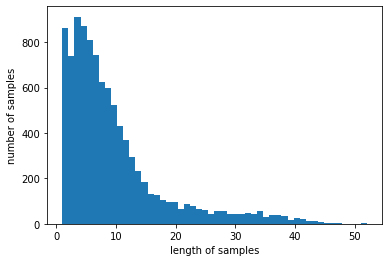

In [31]:
# 서로 다른 길이의 샘플들의 길이를 동일하게 맞춰주는 패딩 작업을 진행
print('리뷰의 최대 길이 : ', max(len(review) for review in x_train))
print('리뷰의 평균 길이 : ', sum(map(len, x_train))/len(x_train))
plt.hist([len(review) for review in x_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [32]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
      count = count + 1
  print(f'전체 샘플 중 길이가 {count}이하인 샘플의 비율 : {(count / len(nested_list))*100}')

In [33]:
max_len = 30
below_threshold_len(max_len, x_train)

전체 샘플 중 길이가 9357이하인 샘플의 비율 : 95.43090260071392


In [34]:
# 모든 샘플의 길이를 30으로 맞추겠다.
x_train = pad_sequences(x_train, maxlen=max_len)
x_test = pad_sequences(x_test, maxlen=max_len)

# 2. LSTM으로 감성분류하기

In [35]:
# 하이퍼파라미터인 임베딩 벡터의 차원은 100
# 은닉 상태의 크기는 128로 함.
# 배치크기는 64로 하고 15 에포크를 수행하겠음

embedding_dim = 100
hidden_units = 128

clear_session()
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
121/123 [============================>.] - ETA: 0s - loss: 0.5395 - acc: 0.7235
Epoch 1: val_acc improved from -inf to 0.78735, saving model to best_model.h5
123/123 [==============================] - 12s 23ms/step - loss: 0.5400 - acc: 0.7239 - val_loss: 0.4564 - val_acc: 0.7874
Epoch 2/15
121/123 [============================>.] - ETA: 0s - loss: 0.3538 - acc: 0.8503
Epoch 2: val_acc improved from 0.78735 to 0.80061, saving model to best_model.h5
123/123 [==============================] - 2s 15ms/step - loss: 0.3538 - acc: 0.8501 - val_loss: 0.4463 - val_acc: 0.8006
Epoch 3/15
121/123 [============================>.] - ETA: 0s - loss: 0.2988 - acc: 0.8745
Epoch 3: val_acc improved from 0.80061 to 0.80520, saving model to best_model.h5
123/123 [==============================] - 2s 15ms/step - loss: 0.3000 - acc: 0.8743 - val_loss: 0.4521 - val_acc: 0.8052
Epoch 4/15
121/123 [============================>.] - ETA: 0s - loss: 0.2673 - acc: 0.8883
Epoch 4: val_acc did not impr

In [36]:
loaded_model = load_model('best_model.h5')
print('테스트 정확도 : %.4f' %(loaded_model.evaluate(x_test, y_test)[1]))

93/93 [==============================] - 1s 5ms/step - loss: 0.4541 - acc: 0.7973
테스트 정확도 : 0.7973


In [37]:
y_pred = loaded_model.predict(x_test)

In [44]:
y_test.shape

(2960,)

In [48]:
y_pred = y_pred.reshape(-1)

In [50]:
y_pred = np.where(y_pred > 0.5, 1, 0)

In [51]:
acc = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'정확도:{acc:0.2f}', f'민감도:{recall:0.2f}', f'정밀도:{precision:0.2f}', f'f1_score:{f1:0.2f}', sep='  |  ')

정확도:0.80  |  민감도:0.77  |  정밀도:0.82  |  f1_score:0.80
